<a href="https://colab.research.google.com/github/Aquib88raza/image-classification-ANKLE/blob/main/Another_copy_of_ankle_BalanceSVM94_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import numpy as np
import cv2
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Define the path to your image directories for healthy and ill samples
normal_path = "/content/drive/MyDrive/Ankle_balance/normal"
ill_path = "/content/drive/MyDrive/Ankle_balance/ill"

# Create lists to store image data and labels
dataset_images = []
dataset_labels = []

# Reading images from the normal directory
for files in os.listdir(normal_path):
    if files.endswith(".jpg"):
        file_path = os.path.join(normal_path, files)
        image = cv2.imread(file_path)
        if image is not None and not image.size == 0:
            size = (256, 256)  # Define the size for resizing images (InceptionV3 input size)
            image = cv2.resize(image, size, interpolation=cv2.INTER_AREA)
            dataset_images.append(image)
            dataset_labels.append(0)  # Label for healthy images

# Reading images from the ill directory
for files in os.listdir(ill_path):
    if files.endswith(".jpg"):
        file_path = os.path.join(ill_path, files)
        image = cv2.imread(file_path)
        if image is not None and not image.size == 0:
            size = (256, 256)  # Define the size for resizing images (InceptionV3 input size)
            image = cv2.resize(image, size, interpolation=cv2.INTER_AREA)
            dataset_images.append(image)
            dataset_labels.append(1)  # Label for ill images

# Convert the lists to NumPy arrays
dataset_images = np.array(dataset_images)
dataset_labels = np.array(dataset_labels)

# Normalize pixel values to the range [0, 1]
dataset_images = dataset_images / 255.0

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(dataset_images, dataset_labels, test_size=0.2, random_state=seed)


# Calculate the total number of images
total_images = len(dataset_images)
print("Total number of images:", total_images)

# Calculate the number of images in the training set
num_train_images = len(X_train)
print("Number of images in the training set:", num_train_images)

# Calculate the number of images in the testing set
num_test_images = len(X_test)
print("Number of images in the testing set:", num_test_images)



Total number of images: 144
Number of images in the training set: 115
Number of images in the testing set: 29


In [ ]:
# Create an InceptionV3 model for feature extraction
base_model = InceptionV3(include_top=False, weights='imagenet', input_shape=(256, 256, 3))

# Add custom layers for classification
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Freeze layers in the base model
for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Train the InceptionV3-based model on the training dataset
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

# Extract features from the InceptionV3-based model for both training and testing datasets
X_train_features = model.predict(X_train)
X_test_features = model.predict(X_test)

# Apply Principal Component Analysis (PCA) to reduce dimensionality
n_components = min(X_train_features.shape[0], X_train_features.shape[1])  # Set it to the minimum
pca = PCA(n_components=n_components)
X_train_pca = pca.fit_transform(X_train_features)
X_test_pca = pca.transform(X_test_features)

# Define a range of hyperparameters to search over for SVM
param_grid = {
    'C': [1, 10, 50, 70, 100],  # Values of regularization parameter C
    'gamma': ['scale', 'auto'],  # Kernel coefficient for 'rbf', 'poly', and 'sigmoid'
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],  # Different kernel types to try
    'class_weight': [None, 'balanced']
}

# Create the SVM classifier
svm_classifier = SVC()

# Perform grid search with cross-validation
grid_search = GridSearchCV(svm_classifier, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Fit the grid search to the training data with PCA features
grid_search.fit(X_train_pca, y_train)

# Get the best parameters and best accuracy
best_params = grid_search.best_params_
best_accuracy = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best Accuracy:", best_accuracy)

Epoch 1/10
4/4 [==============================] - 32s 7s/step - loss: 0.6523 - accuracy: 0.6435 - val_loss: 0.5189 - val_accuracy: 0.8276
Epoch 2/10
4/4 [==============================] - 26s 7s/step - loss: 0.5346 - accuracy: 0.7565 - val_loss: 0.4745 - val_accuracy: 0.8276
Epoch 3/10
4/4 [==============================] - 23s 6s/step - loss: 0.4547 - accuracy: 0.8609 - val_loss: 0.4726 - val_accuracy: 0.8621
Epoch 4/10
4/4 [==============================] - 26s 6s/step - loss: 0.4202 - accuracy: 0.8261 - val_loss: 0.4319 - val_accuracy: 0.8276
Epoch 5/10
4/4 [==============================] - 25s 7s/step - loss: 0.3789 - accuracy: 0.8609 - val_loss: 0.4160 - val_accuracy: 0.8276
Epoch 6/10
4/4 [==============================] - 29s 7s/step - loss: 0.3534 - accuracy: 0.8609 - val_loss: 0.4164 - val_accuracy: 0.7931
Epoch 7/10
4/4 [==============================] - 23s 6s/step - loss: 0.3231 - accuracy: 0.8783 - val_loss: 0.3900 - val_accuracy: 0.8621
Epoch 8/10
4/4 [==================

Classification Report for SVM on the testing dataset:
               precision    recall  f1-score   support

           0       0.86      0.75      0.80        16
           1       0.73      0.85      0.79        13

    accuracy                           0.79        29
   macro avg       0.80      0.80      0.79        29
weighted avg       0.80      0.79      0.79        29



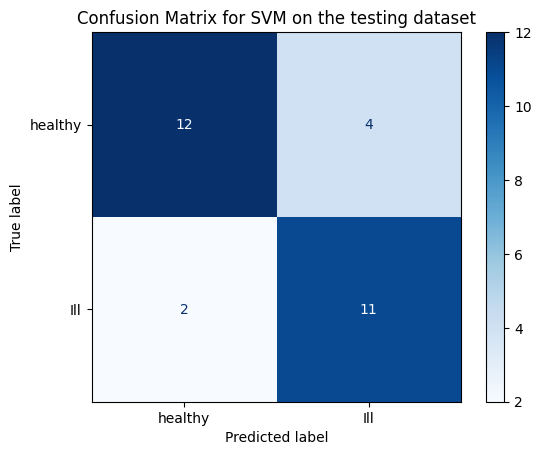

In [ ]:
# Predict on the testing dataset using the best SVM classifier with PCA features
best_svm_classifier = grid_search.best_estimator_
y_test_pred = best_svm_classifier.predict(X_test_pca)

# Generate classification report for the testing dataset
test_report = classification_report(y_test, y_test_pred)
print("Classification Report for SVM on the testing dataset:\n", test_report)

# Calculate the confusion matrix for the testing dataset
test_cm = confusion_matrix(y_test, y_test_pred)

# Display the confusion matrix for the testing dataset
test_disp = ConfusionMatrixDisplay(confusion_matrix=test_cm, display_labels=["healthy", "Ill"])
test_disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for SVM on the testing dataset")
plt.show()

Classification Report for SVM on the training dataset:
               precision    recall  f1-score   support

           0       0.93      0.95      0.94        56
           1       0.95      0.93      0.94        59

    accuracy                           0.94       115
   macro avg       0.94      0.94      0.94       115
weighted avg       0.94      0.94      0.94       115



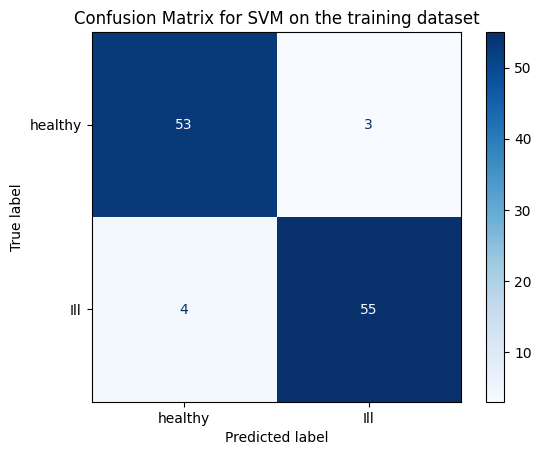

In [ ]:
# Predict on the training dataset using the best SVM classifier with PCA features
y_train_pred = best_svm_classifier.predict(X_train_pca)

# Generate classification report for the training dataset
train_report = classification_report(y_train, y_train_pred)
print("Classification Report for SVM on the training dataset:\n", train_report)

# Calculate the confusion matrix for the training dataset
train_cm = confusion_matrix(y_train, y_train_pred)

# Display the confusion matrix for the training dataset
train_disp = ConfusionMatrixDisplay(confusion_matrix=train_cm, display_labels=["healthy", "Ill"])
train_disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for SVM on the training dataset")
plt.show()

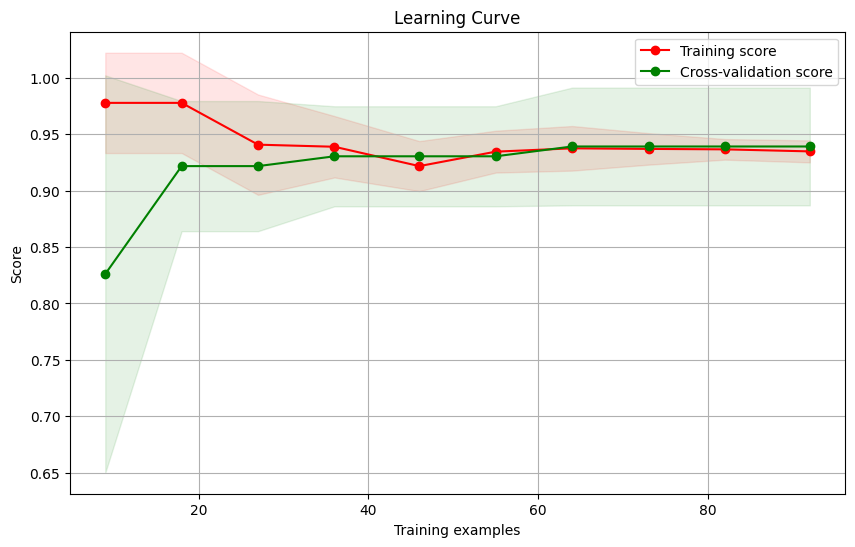

In [ ]:
from sklearn.model_selection import learning_curve
# Plot the learning curve
train_sizes, train_scores, test_scores = learning_curve(
    best_svm_classifier, X_train_pca, y_train, cv=5, train_sizes=np.linspace(0.1, 1.0, 10))

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.title("Learning Curve")
plt.xlabel("Training examples")
plt.ylabel("Score")
plt.grid()

plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1,
                 color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1,
                 color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

plt.legend(loc="best")
plt.show()

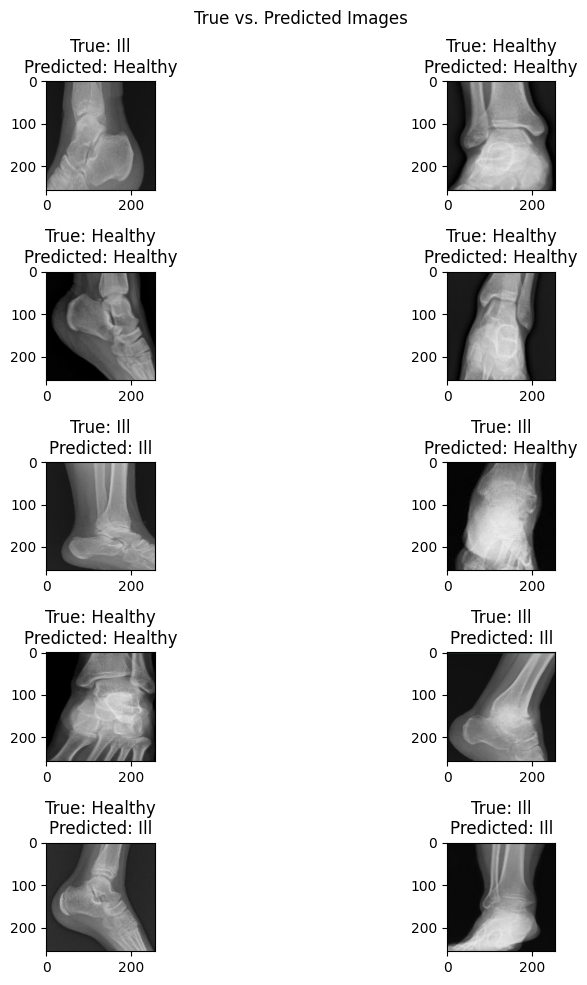

In [ ]:
import random

# Randomly select some images for display (e.g., 10 images)
num_samples_to_display = 10
random_indices = random.sample(range(len(X_test)), num_samples_to_display)

# Create a figure to display the images
plt.figure(figsize=(10, 10))
plt.suptitle("True vs. Predicted Images")

# Define the number of rows and columns for image display
num_rows = 5
num_cols = 2

for i, index in enumerate(random_indices):
    plt.subplot(num_rows, num_cols, i + 1)
    plt.imshow(X_test[index])  # Display the image
    true_label = "Healthy" if y_test[index] == 0 else "Ill"
    predicted_label = "Healthy" if y_test_pred[index] == 0 else "Ill"
    plt.title(f"True: {true_label}\nPredicted: {predicted_label}")

plt.tight_layout()
plt.show()


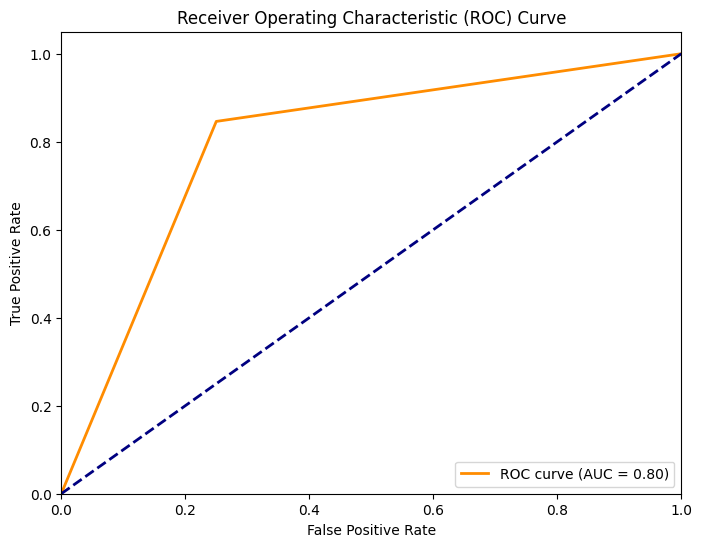

AUC (Area Under the Curve): 0.80


In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score, auc

# Calculate ROC curve for testing data
fpr, tpr, thresholds = roc_curve(y_test, y_test_pred)

# Calculate AUC for testing data
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Display AUC value
print("AUC (Area Under the Curve): {:.2f}".format(roc_auc))


In [ ]:
# Calculate sensitivity and specificity for the training dataset
tn_train, fp_train, fn_train, tp_train = train_cm.ravel()
sensitivity_train = tp_train / (tp_train + fn_train)
specificity_train = tn_train / (tn_train + fp_train)

print("Sensitivity (Training):", sensitivity_train)
print("Specificity (Training):", specificity_train)

# Calculate sensitivity and specificity for the testing dataset
tn_test, fp_test, fn_test, tp_test = test_cm.ravel()
sensitivity_test = tp_test / (tp_test + fn_test)
specificity_test = tn_test / (tn_test + fp_test)

print("Sensitivity (Testing):", sensitivity_test)
print("Specificity (Testing):", specificity_test)


Sensitivity (Training): 0.9322033898305084
Specificity (Training): 0.9464285714285714
Sensitivity (Testing): 0.8461538461538461
Specificity (Testing): 0.75


In [ ]:
from sklearn.model_selection import cross_val_score

# Perform cross-validation to get cross-validation scores
cross_val_scores = cross_val_score(best_svm_classifier, X_train_pca, y_train, cv=5, scoring='accuracy')

# Print the cross-validation scores
print("Cross-Validation Scores:", cross_val_scores)
print("Mean Cross-Validation Score:", cross_val_scores.mean())

# Calculate the variance of cross-validation scores
variance = cross_val_scores.var()
print("Cross-Validation Variance:", variance)

# Print the classification report for the training dataset
train_report = classification_report(y_train, y_train_pred)
print("Classification Report for SVM on the training dataset:\n", train_report)






Cross-Validation Scores: [1.         0.86956522 0.91304348 1.         0.91304348]
Mean Cross-Validation Score: 0.9391304347826086
Cross-Validation Variance: 0.0027221172022684325
Classification Report for SVM on the training dataset:
               precision    recall  f1-score   support

           0       0.93      0.95      0.94        56
           1       0.95      0.93      0.94        59

    accuracy                           0.94       115
   macro avg       0.94      0.94      0.94       115
weighted avg       0.94      0.94      0.94       115



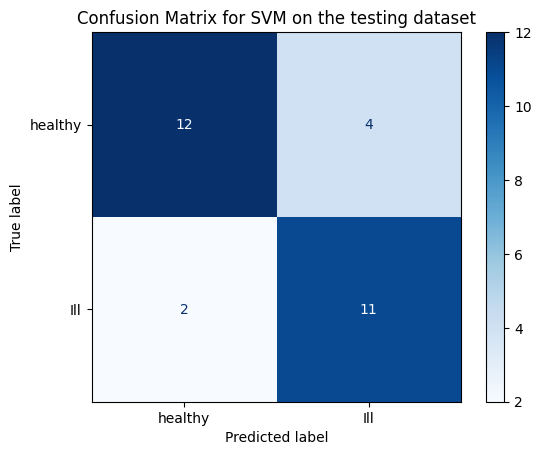

Sensitivity (True Positive Rate): 0.8461538461538461
Specificity (True Negative Rate): 0.75


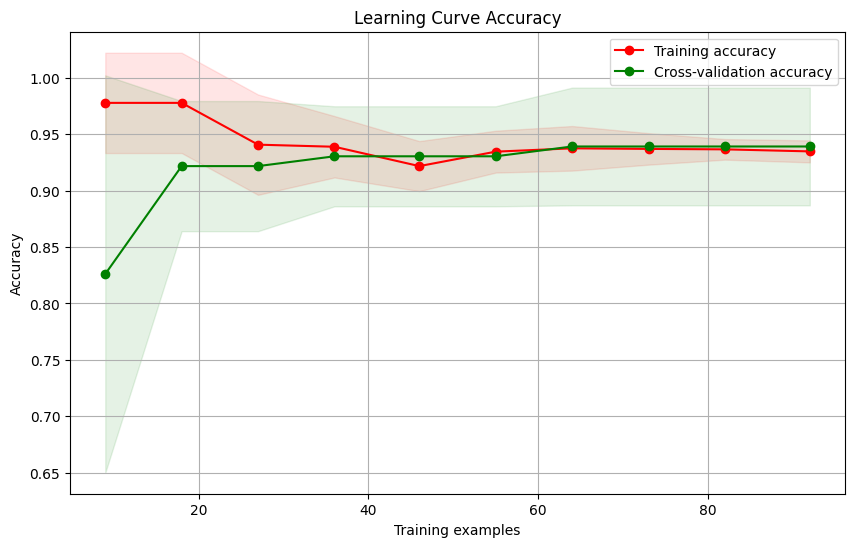

In [ ]:
# Import functions for calculating sensitivity and specificity
from sklearn.metrics import recall_score, precision_score

# Display the confusion matrix for the testing dataset
test_disp = ConfusionMatrixDisplay(confusion_matrix=test_cm, display_labels=["healthy", "Ill"])
test_disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for SVM on the testing dataset")
plt.show()

# Calculate sensitivity and specificity
sensitivity = recall_score(y_test, y_test_pred)
specificity = recall_score(y_test, y_test_pred, pos_label=0)

print("Sensitivity (True Positive Rate):", sensitivity)
print("Specificity (True Negative Rate):", specificity)

# Plot the learning curve accuracy
plt.figure(figsize=(10, 6))
plt.title("Learning Curve Accuracy")
plt.xlabel("Training examples")
plt.ylabel("Accuracy")
plt.grid()

plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training accuracy")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation accuracy")

plt.legend(loc="best")
plt.show()


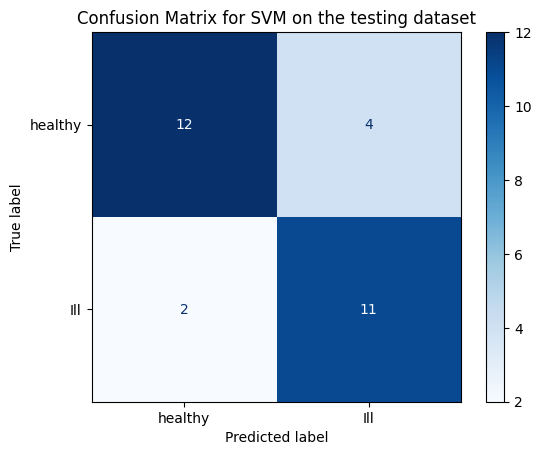

Sensitivity (True Positive Rate) - Testing: 0.8461538461538461
Specificity (True Negative Rate) - Testing: 0.75


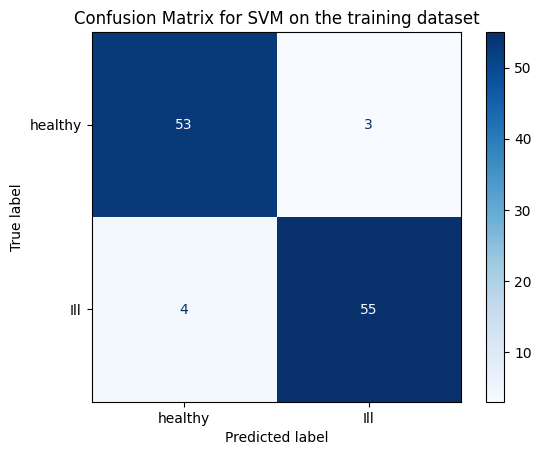

Sensitivity (True Positive Rate) - Training: 0.9322033898305084
Specificity (True Negative Rate) - Training: 0.9464285714285714


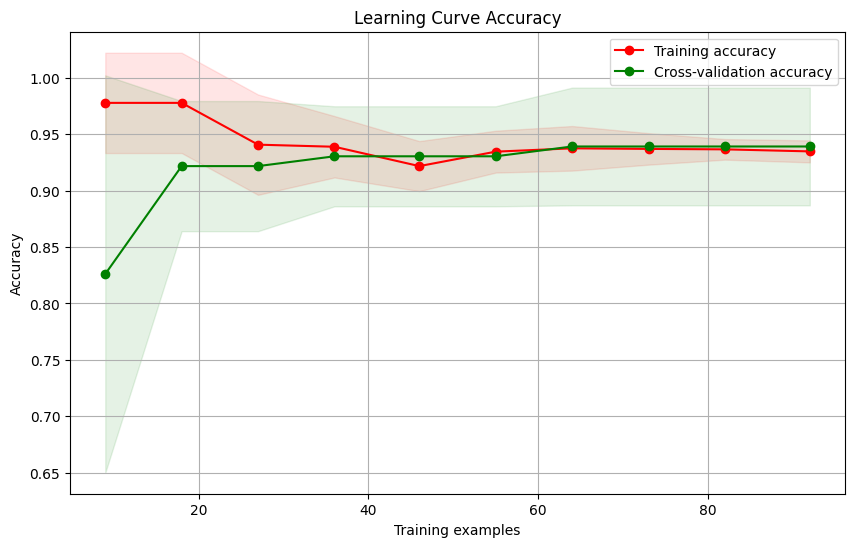

In [ ]:
# Display the confusion matrix for the testing dataset
test_disp = ConfusionMatrixDisplay(confusion_matrix=test_cm, display_labels=["healthy", "Ill"])
test_disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for SVM on the testing dataset")
plt.show()

# Calculate sensitivity and specificity for testing data
sensitivity_test = recall_score(y_test, y_test_pred)
specificity_test = recall_score(y_test, y_test_pred, pos_label=0)

print("Sensitivity (True Positive Rate) - Testing:", sensitivity_test)
print("Specificity (True Negative Rate) - Testing:", specificity_test)

# Display the confusion matrix for the training dataset
train_disp = ConfusionMatrixDisplay(confusion_matrix=train_cm, display_labels=["healthy", "Ill"])
train_disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for SVM on the training dataset")
plt.show()

# Calculate sensitivity and specificity for training data
sensitivity_train = recall_score(y_train, y_train_pred)
specificity_train = recall_score(y_train, y_train_pred, pos_label=0)

print("Sensitivity (True Positive Rate) - Training:", sensitivity_train)
print("Specificity (True Negative Rate) - Training:", specificity_train)

# Plot the learning curve accuracy for both training and testing data
plt.figure(figsize=(10, 6))
plt.title("Learning Curve Accuracy")
plt.xlabel("Training examples")
plt.ylabel("Accuracy")
plt.grid()

plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training accuracy")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation accuracy")

plt.legend(loc="best")
plt.show()


In [ ]:
from sklearn.metrics import classification_report

# Print classification report for the testing dataset with sensitivity and specificity
test_report = classification_report(y_test, y_test_pred, target_names=["healthy", "Ill"])

# Calculate sensitivity and specificity for testing data
sensitivity_test = recall_score(y_test, y_test_pred)
specificity_test = recall_score(y_test, y_test_pred, pos_label=0)

print("Classification Report - Testing:\n", test_report)
print("Sensitivity (True Positive Rate) - Testing:", sensitivity_test)
print("Specificity (True Negative Rate) - Testing:", specificity_test)

# Print classification report for the training dataset with sensitivity and specificity
train_report = classification_report(y_train, y_train_pred, target_names=["healthy", "Ill"])

# Calculate sensitivity and specificity for training data
sensitivity_train = recall_score(y_train, y_train_pred)
specificity_train = recall_score(y_train, y_train_pred, pos_label=0)

print("Classification Report - Training:\n", train_report)
print("Sensitivity (True Positive Rate) - Training:", sensitivity_train)
print("Specificity (True Negative Rate) - Training:", specificity_train)


Classification Report - Testing:
               precision    recall  f1-score   support

     healthy       0.86      0.75      0.80        16
         Ill       0.73      0.85      0.79        13

    accuracy                           0.79        29
   macro avg       0.80      0.80      0.79        29
weighted avg       0.80      0.79      0.79        29

Sensitivity (True Positive Rate) - Testing: 0.8461538461538461
Specificity (True Negative Rate) - Testing: 0.75
Classification Report - Training:
               precision    recall  f1-score   support

     healthy       0.93      0.95      0.94        56
         Ill       0.95      0.93      0.94        59

    accuracy                           0.94       115
   macro avg       0.94      0.94      0.94       115
weighted avg       0.94      0.94      0.94       115

Sensitivity (True Positive Rate) - Training: 0.9322033898305084
Specificity (True Negative Rate) - Training: 0.9464285714285714


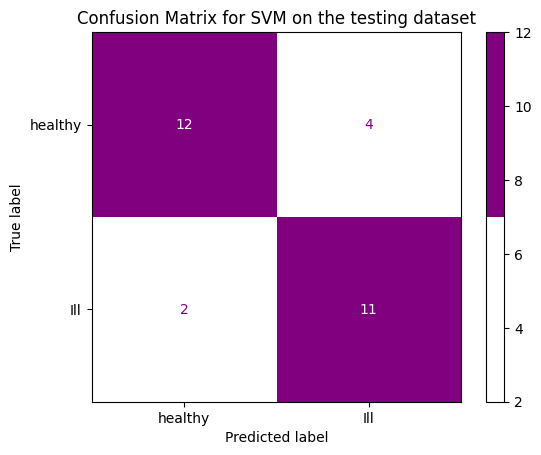

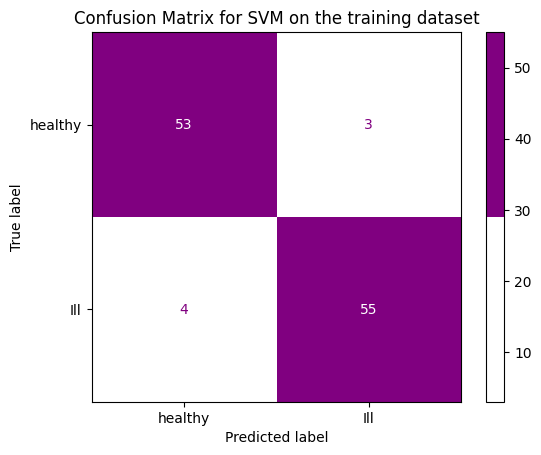

Classification Report - Testing:
Healthy:
  Sensitivity (True Positive Rate) - Testing: 0.75
  Specificity (True Negative Rate) - Testing: 0.75
Ill:
  Sensitivity (True Positive Rate) - Testing: 0.8461538461538461
  Specificity (True Negative Rate) - Testing: 0.75

Classification Report - Training:
Healthy:
  Sensitivity (True Positive Rate) - Training: 0.9464285714285714
  Specificity (True Negative Rate) - Training: 0.9464285714285714
Ill:
  Sensitivity (True Positive Rate) - Training: 0.9322033898305084
  Specificity (True Negative Rate) - Training: 0.9464285714285714


In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import recall_score

# Calculate sensitivity and specificity for testing data
sensitivity_test = recall_score(y_test, y_test_pred)
specificity_test = recall_score(y_test, y_test_pred, pos_label=0)

# Define a custom color map with purple and white colors
custom_cmap = plt.cm.colors.ListedColormap(['white', 'purple'])

# Display the confusion matrix for the testing dataset with custom color map
test_disp = ConfusionMatrixDisplay(confusion_matrix=test_cm, display_labels=["healthy", "Ill"])
test_disp.plot(cmap=custom_cmap)
plt.title("Confusion Matrix for SVM on the testing dataset")
plt.show()

# Calculate sensitivity and specificity for training data
sensitivity_train = recall_score(y_train, y_train_pred)
specificity_train = recall_score(y_train, y_train_pred, pos_label=0)

# Display the confusion matrix for the training dataset with custom color map
train_disp = ConfusionMatrixDisplay(confusion_matrix=train_cm, display_labels=["healthy", "Ill"])
train_disp.plot(cmap=custom_cmap)
plt.title("Confusion Matrix for SVM on the training dataset")
plt.show()

# Print classification report for the testing dataset with sensitivity and specificity, and classification names
test_report = classification_report(y_test, y_test_pred, target_names=["healthy", "Ill"],
                                   output_dict=True)

# Print classification report for the training dataset with sensitivity and specificity, and classification names
train_report = classification_report(y_train, y_train_pred, target_names=["healthy", "Ill"],
                                    output_dict=True)

print("Classification Report - Testing:")
print("Healthy:")
print("  Sensitivity (True Positive Rate) - Testing:", test_report["healthy"]["recall"])
print("  Specificity (True Negative Rate) - Testing:", specificity_test)
print("Ill:")
print("  Sensitivity (True Positive Rate) - Testing:", test_report["Ill"]["recall"])
print("  Specificity (True Negative Rate) - Testing:", specificity_test)

print("\nClassification Report - Training:")
print("Healthy:")
print("  Sensitivity (True Positive Rate) - Training:", train_report["healthy"]["recall"])
print("  Specificity (True Negative Rate) - Training:", specificity_train)
print("Ill:")
print("  Sensitivity (True Positive Rate) - Training:", train_report["Ill"]["recall"])
print("  Specificity (True Negative Rate) - Training:", specificity_train)


In [ ]:
# Calculate the number of healthy and ill data points in the training data
num_healthy = np.sum(y_train == 0)
num_ill = np.sum(y_train == 1)

print("Number of Healthy Samples:", num_healthy)
print("Number of Ill Samples:", num_ill)


Number of Healthy Samples: 56
Number of Ill Samples: 59
